https://docs.dgl.ai/tutorials/basics/4_batch.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import dgl
from dgl import DGLGraph
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

import networkx as nx
import copy
import os
from rdkit import Chem
from rdkit.Chem import RDConfig
import numpy as np

In [2]:
ELEM_LIST = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'Al', 'I', 'B', 'K', 'Se', 'Zn', 'H', 'Cu', 'Mn', 'unknown']

ATOM_FDIM = len(ELEM_LIST) + 6 + 5 + 1
MAX_ATOMNUM =60
BOND_FDIM = 5 
MAX_NB = 10

PAPER = os.getenv('PAPER', False)

def onek_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]

# Note that during graph decoding they don't predict stereochemistry-related
# characteristics (i.e. Chiral Atoms, E-Z, Cis-Trans).  Instead, they decode
# the 2-D graph first, then enumerate all possible 3-D forms and find the
# one with highest score.
'''
def atom_features(atom):
    return (torch.Tensor(onek_encoding_unk(atom.GetSymbol(), ELEM_LIST)
            + onek_encoding_unk(atom.GetDegree(), [0,1,2,3,4,5])
            + onek_encoding_unk(atom.GetFormalCharge(), [-1,-2,1,2,0])
            + [atom.GetIsAromatic()]))
'''
def atom_features(atom):
    return (onek_encoding_unk(atom.GetSymbol(), ELEM_LIST)
            + onek_encoding_unk(atom.GetDegree(), [0,1,2,3,4,5])
            + onek_encoding_unk(atom.GetFormalCharge(), [-1,-2,1,2,0])
            + [atom.GetIsAromatic()])

def bond_features(bond):
    bt = bond.GetBondType()
    return (torch.Tensor([bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE, bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC, bond.IsInRing()]))

def mol2dgl_single(mols):
    cand_graphs = []
    n_nodes = 0
    n_edges = 0
    bond_x = []

    for mol in mols:
        n_atoms = mol.GetNumAtoms()
        n_bonds = mol.GetNumBonds()
        g = DGLGraph()        
        nodeF = []
        for i, atom in enumerate(mol.GetAtoms()):
            assert i == atom.GetIdx()
            nodeF.append(atom_features(atom))
        g.add_nodes(n_atoms)

        bond_src = []
        bond_dst = []
        for i, bond in enumerate(mol.GetBonds()):
            a1 = bond.GetBeginAtom()
            a2 = bond.GetEndAtom()
            begin_idx = a1.GetIdx()
            end_idx = a2.GetIdx()
            features = bond_features(bond)

            bond_src.append(begin_idx)
            bond_dst.append(end_idx)
            bond_x.append(features)
            bond_src.append(end_idx)
            bond_dst.append(begin_idx)
            bond_x.append(features)
        g.add_edges(bond_src, bond_dst)
        g.ndata['h'] = torch.Tensor(nodeF)
        cand_graphs.append(g)
    return cand_graphs
msg = fn.copy_src(src="h", out="m")


In [3]:
solcls = {'(A) low':0, '(B) medium':1, '(C) high':2}
train_mols = [m for m in Chem.SDMolSupplier(os.path.join(RDConfig.RDDocsDir,'Book/data/solubility.train.sdf'))]
train_y = [solcls[m.GetProp('SOL_classification')] for m in train_mols]
test_mols = [m for m in Chem.SDMolSupplier(os.path.join(RDConfig.RDDocsDir,'Book/data/solubility.test.sdf'))]
test_y = [solcls[m.GetProp('SOL_classification')] for m in test_mols]

In [4]:
train_graphs = mol2dgl_single(train_mols)
test_graphs = mol2dgl_single(test_mols)

In [5]:
def collate(sample):
    graphs, labels = map(list,zip(*sample))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [6]:
def reduce(nodes):
    # summazation by avarage is different part
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

In [7]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation
    
    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h': h}
    

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)
    
    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        h =  g.ndata.pop('h')
        #print(h.shape)
        return h
    
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.layers = nn.ModuleList([GCN(in_dim, hidden_dim, F.relu),
                                    GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)
    def forward(self, g):
        h = g.ndata['h']
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [8]:
dataset = list(zip(train_graphs, train_y))
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate)

In [9]:
model = Classifier(ATOM_FDIM, 256, len(solcls))

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (layers): ModuleList(
    (0): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=35, out_features=256, bias=True)
      )
    )
    (1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (classify): Linear(in_features=256, out_features=3, bias=True)
)

In [11]:
epoch_losses = []
for epoch in range(200):
    epoch_loss = 0
    for i, (bg, label) in enumerate(data_loader):
        bg.set_e_initializer(dgl.init.zero_initializer)
        bg.set_n_initializer(dgl.init.zero_initializer)        
        pred = model(bg)
        loss = loss_func(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (i + 1)
    if (epoch+1) % 20 == 0:
        print('Epoch {}, loss {:.4f}'.format(epoch+1, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 20, loss 0.6104
Epoch 40, loss 0.5616
Epoch 60, loss 0.5348
Epoch 80, loss 0.5095
Epoch 100, loss 0.4915
Epoch 120, loss 0.5163
Epoch 140, loss 0.5348
Epoch 160, loss 0.4385
Epoch 180, loss 0.4421
Epoch 200, loss 0.4318


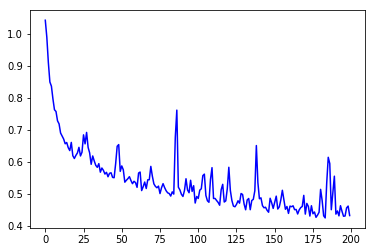

In [12]:
plt.plot(epoch_losses, c='b')

In [13]:
model.eval()
test_bg = dgl.batch(test_graphs)
test_y_tensor = torch.tensor(test_y).float().view(-1,1)

In [14]:
test_bg.set_e_initializer(dgl.init.zero_initializer)
test_bg.set_n_initializer(dgl.init.zero_initializer)

In [15]:
logit = model(test_bg)

In [16]:
probs = torch.softmax(logit, 1).detach().numpy()

In [17]:
pred_y = np.argmax(probs,1)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [19]:
accuracy_score(test_y, pred_y)

0.7587548638132295

In [20]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.70      0.86      0.78       102
           1       0.79      0.64      0.71       115
           2       0.87      0.82      0.85        40

   micro avg       0.76      0.76      0.76       257
   macro avg       0.79      0.78      0.78       257
weighted avg       0.77      0.76      0.76       257



In [21]:
print(confusion_matrix(test_y, pred_y))

[[88 14  0]
 [36 74  5]
 [ 1  6 33]]


In [22]:
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import rdMolDescriptors
from sklearn.preprocessing import normalize

In [23]:
# generate 3D conf
train_mols2 = copy.deepcopy(train_mols)
test_mols2 = copy.deepcopy(test_mols)

ps = AllChem.ETKDGv2()
for m in train_mols2:
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m,ps)
for m in test_mols2:
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m,ps)

In [24]:
def calc_dragon_type_desc(mol):
    return rdMolDescriptors.CalcAUTOCORR3D(mol) + rdMolDescriptors.CalcMORSE(mol) + \
        rdMolDescriptors.CalcRDF(mol) + rdMolDescriptors.CalcWHIM(mol)
train_X = normalize([calc_dragon_type_desc(m) for m in train_mols2])
test_X = normalize([calc_dragon_type_desc(m) for m in test_mols2])

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rfc = RandomForestClassifier(n_estimators=100)

In [27]:
rfc.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
rf_pred_y = rfc.predict(test_X)

In [29]:
accuracy_score(test_y, rf_pred_y)

0.7587548638132295

In [30]:
print(classification_report(test_y, rf_pred_y))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       102
           1       0.79      0.66      0.72       115
           2       0.67      0.75      0.71        40

   micro avg       0.76      0.76      0.76       257
   macro avg       0.74      0.76      0.75       257
weighted avg       0.76      0.76      0.76       257



In [31]:
print(confusion_matrix(test_y, rf_pred_y))

[[89 11  2]
 [26 76 13]
 [ 1  9 30]]
